In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils
data = pd.read_csv("../Data/hk_database_prueba.csv")
data.head(5)

,id,cx_curp,df_nacimiento,cs_sexo,first_cx,last_cx,count_cx_w,years_cx,window,x_start,...,I15,I159,I139,I131,I130,I11,I151,I158,I13,I132
0,#EHA6911199IMKERC1-1,#EHA6911199IMKERC1,19/11/1969,F,16/04/2018,06/10/2020,24.0,3,1,16/04/2018,...,0,0,0,0,0,0,0,0,0,0
1,#EHE671124ISYRCRC1-1,#EHE671124ISYRCRC1,24/11/1967,F,04/04/2017,11/12/2019,1.0,3,1,04/04/2017,...,0,0,0,0,0,0,0,0,0,0
2,AAAA2201010EDBBRC1-1,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,29.0,7,1,18/01/2005,...,0,0,0,0,0,0,0,0,0,0
3,AAAA2201010EDBBRC1-2,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,27.0,7,2,18/01/2006,...,0,0,0,0,0,0,0,0,0,0
4,AAAA2201010EDBBRC1-3,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,24.0,7,3,18/01/2007,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data['first_cx']= pd.to_datetime(data['first_cx'])
data['last_cx']= pd.to_datetime(data['last_cx'])
data['df_nacimiento']= pd.to_datetime(data['df_nacimiento'])

data['edad'] = np.nan
for i in range(len(data['cx_curp'])): 
    if pd.isna(data['df_nacimiento'][i]):
        data['edad'][i] = np.nan        
    else: 
        data['edad'][i] = (int(data['first_cx'][i].year-data['df_nacimiento'][i].year)+\
                        int(data['last_cx'][i].year-data['df_nacimiento'][i].year))/2
        
data["edad_range"] = np.nan
data.loc[(data['edad'] <  11), 'edad_range'] = 1#'hasta 10 años'
data.loc[(data['edad'] > 10) & (data['edad'] <= 20), 'edad_range'] = 2#'11-20'
data.loc[(data['edad'] > 20) & (data['edad'] <= 30), 'edad_range'] = 3#'21-30'
data.loc[(data['edad'] > 30) & (data['edad'] <= 40), 'edad_range'] = 4#'31-40'
data.loc[(data['edad'] > 40) & (data['edad'] <= 50), 'edad_range'] = 5#'41-50'
data.loc[(data['edad'] > 50) & (data['edad'] <= 60), 'edad_range'] = 6#'51-60'
data.loc[(data['edad'] > 60) & (data['edad'] <= 70), 'edad_range'] = 7#'61-70'
data.loc[(data['edad'] > 70) & (data['edad'] <= 80), 'edad_range'] = 8#'71-80'
data.loc[(data['edad'] > 80) & (data['edad'] <= 90), 'edad_range'] = 9#'81-90'
data.loc[(data['edad'] > 90  ), 'edad_range'] = 10#'91 y más'

data["imc_calculado"] = np.nan
data["imc_calculado"] = np.where(~pd.isna(data["fn_peso_median"])&~pd.isna(data["fn_talla_median"]), \
                                       (data["fn_peso_median"]/(data["fn_talla_median"]**2)), 
                                       np.nan)
data["imc_range"] = np.nan
data.loc[(data['imc_calculado'] <  18.5), 'imc_range'] = 1#'Bajo peso'
data.loc[(data['imc_calculado'] >= 18.5) & (data['imc_calculado'] < 25), 'imc_range'] = 2#'Peso normal'
data.loc[(data['imc_calculado'] >= 25  ) & (data['imc_calculado'] < 30), 'imc_range'] = 3#'Sobrepeso'
data.loc[(data['imc_calculado'] >= 30  ), 'imc_range'] = 4#'Obesidad'

In [4]:
data = data.drop(['id','cx_curp','df_nacimiento','cs_sexo','first_cx','last_cx','x_start','x_end','y_start','y_end',
         'I10X','I119','I129','I110','I150','I120','I12','I15','I159','I139','I131','I130','I11','I151',
         'I158','I13','I132','edad','imc_calculado','anio_dx','fn_peri_cefalico_mean',
 'fn_peri_cefalico_median',
 'fn_peri_cefalico_max',
 'fn_peri_cefalico_min',
 'fn_peri_cefalico_std',
 'fn_peri_toracico_mean',
 'fn_peri_toracico_median',
 'fn_peri_toracico_max',
 'fn_peri_toracico_min',
 'fn_peri_toracico_std',
 'fn_peri_abdominal_mean',
 'fn_peri_abdominal_median',
 'fn_peri_abdominal_max',
 'fn_peri_abdominal_min',
 'fn_peri_abdominal_std',
 'fn_pvc_mean',
 'fn_pvc_median',
 'fn_pvc_max',
 'fn_pvc_min',
 'fn_pvc_std',
 'fn_temp_incubadora_mean',
 'fn_temp_incubadora_median',
 'fn_temp_incubadora_max',
 'fn_temp_incubadora_min',
 'fn_temp_incubadora_std'], axis=1)

In [5]:
data.rename(columns = {'Tirotoxicosis [hipertiroidismo]':'Tirotoxicosis_hipertiroidismo', 
                     'Deficiencia de niacina [pelagra]':'Deficiencia de niacina_pelagra'}, inplace = True)

In [6]:
X = data.loc[:, data.columns != 'label']
print(X.shape)
Y = data[["label"]]
print(Y.shape)

(3997, 348)
(3997, 1)


<AxesSubplot:>

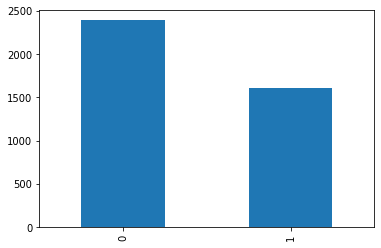

In [7]:
data['label'].value_counts().plot.bar()

In [8]:
data.shape

(3997, 349)

In [9]:
data.drop(['ANTIHIPERTENSIVOS_count','ANTIHIPERTENSIVOS_sum','ANTIHIPERTENSIVOS_mean',\
           'ANTIVERTIGINOSOS_sum','ANTIVERTIGINOSOS_count','ANTIVERTIGINOSOS_mean',\
           'Enfermedad cardíaca hipertensiva','Enfermedad isquémica crónica del corazón',
          'Enfermedad cardíaca hipertensiva sin insuficiencia cardíaca (congestiva)',
          'Enfermedad renal hipertensiva sin insuficiencia renal',
          'Hipertensión secundaria no especificada','Hipertensión secundaria',
          'Enfermedad cardiorrenal hipertensiva','ANTIARRITMICOS_count','ANTIARRITMICOS_sum',
          'Enfermedades del sistema circulatorio'], axis=1, inplace=True)

In [10]:
col = list(data.columns)
col

['count_cx_w',
 'years_cx',
 'window',
 'Diabetes mellitus tipo 2',
 'label',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas otras consecuencias de causas externas',
 'Tumores (neoplasias)',
 'Malformaciones congenitas deformidades y anomalias cromosomicas',
 'Enfermedades de la sangre y de los o

### Imputaciones

In [11]:
# Imputatio
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(data))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,24.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,4.0


In [12]:
d_inp.shape

(3997, 333)

In [13]:
d_inp.columns = col
d_inp

,count_cx_w,years_cx,window,Diabetes mellitus tipo 2,label,Enfermedades endocrinas nutricionales y metabolicas,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema nervioso,Factores que influyen en el estado de salud y contacto con los servicios de salud,Enfermedades del sistema genitourinario,...,FORMULAS_NUTRICIONALES_COMPLETAS_count,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_sum,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_mean,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_count,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_sum,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_mean,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_count,ANTIARRITMICOS_mean,edad_range,imc_range
0,24.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,4.0


In [14]:
X = d_inp.loc[:, d_inp.columns != 'label']
Y = d_inp[["label"]]

In [15]:
print(X.shape)
print(Y.shape)

(3997, 332)
(3997, 1)


In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=4)

In [17]:
# Parámetros para la mejor selección de variables
grid_param = {
    'n_estimators': [100, 150],
    'min_samples_split': [2, 5, 7, 10,15]
}

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

#Prepareción del GridSearch
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='precision',
                     cv=2)

In [18]:
#Fit del grid search con r
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             param_grid={'min_samples_split': [2, 5, 7, 10, 15],
                         'n_estimators': [100, 150]},
             scoring='precision')

In [19]:
# mejor configuración 
gd_sr.best_estimator_

RandomForestClassifier(oob_score=True, random_state=1234)

In [20]:
gd_sr.best_estimator_.n_features_

332

In [21]:
gd_sr.best_estimator_.oob_score_

0.8998927422238112

### Importancia de variables

In [22]:
best_rf = gd_sr.best_estimator_
best_rf.feature_importances_

array([4.48517343e-02, 8.94221331e-03, 7.25212506e-03, 1.30406919e-02,
       1.53064404e-02, 2.58605970e-03, 1.26174630e-03, 2.17118564e-03,
       1.63966418e-03, 3.38294942e-03, 3.20487367e-03, 4.55011832e-03,
       2.69526908e-03, 1.63704980e-03, 1.41730926e-03, 2.48303113e-03,
       1.87299371e-03, 1.75619533e-03, 1.26572978e-03, 6.87522936e-04,
       5.91547527e-04, 1.26572729e-05, 0.00000000e+00, 0.00000000e+00,
       1.58959319e-04, 3.47617900e-04, 9.76881365e-05, 9.19383619e-04,
       5.74291461e-03, 3.49055531e-04, 7.38174387e-04, 1.51035825e-04,
       7.37045039e-05, 2.56319713e-04, 2.35699599e-05, 4.20631990e-05,
       1.21598327e-04, 1.50997802e-04, 1.05782228e-04, 0.00000000e+00,
       1.30467135e-05, 2.57387928e-04, 3.77476404e-04, 9.60098525e-05,
       0.00000000e+00, 2.08198759e-04, 1.11704090e-05, 1.45337000e-05,
       0.00000000e+00, 9.98910734e-06, 8.77779715e-04, 1.37259232e-05,
       1.10783860e-05, 7.03056041e-05, 1.45696054e-05, 0.00000000e+00,
      

In [23]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [24]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [25]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
190,5.799842e-02,fn_ta_sistolica_max
198,4.532925e-02,fn_ta_diastolica_count
0,4.485173e-02,count_cx_w
330,4.107887e-02,edad_range
183,3.566471e-02,fn_talla_count
177,3.432922e-02,fn_peso_count
188,3.319898e-02,fn_ta_sistolica_mean
192,3.076500e-02,fn_ta_sistolica_count
196,2.639113e-02,fn_ta_diastolica_max
216,2.327106e-02,fn_temperatura_count


In [26]:
col_imp = list(importancias[importancias['importance']>0]['feature'])
col_imp.append('label')
col_imp

['fn_ta_sistolica_max',
 'fn_ta_diastolica_count',
 'count_cx_w',
 'edad_range',
 'fn_talla_count',
 'fn_peso_count',
 'fn_ta_sistolica_mean',
 'fn_ta_sistolica_count',
 'fn_ta_diastolica_max',
 'fn_temperatura_count',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_sum',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_count',
 'fn_ta_sistolica_std',
 'Diabetes mellitus tipo 2 sin mención de complicación',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'fn_ta_sistolica_median',
 'Trastornos del metabolismo de las lipoproteínas y otras lipidemias',
 'Diabetes mellitus tipo 2',
 'VITAMÍNICOS_count',
 'VITAMÍNICOS_sum',
 'fn_ta_diastolica_mean',
 'ANTIDIABÉTICOS_count',
 'fn_ta_diastolica_std',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_count',
 'years_cx',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_sum',
 'in_frec_cardiaca_count',
 'in_frec_respiratoria_count',
 'ANTIDIABÉTICOS_mean',
 'window',
 'in_glucosa_median',
 'fn_peso_mean',
 'fn_peso_median',
 'fn_peso_max',
 'fn_peso_min',
 

In [27]:
d_fe_f = pd.concat([X, Y])

In [28]:
d_fe_f = d_fe_f[col_imp]
d_fe_f

,fn_ta_sistolica_max,fn_ta_diastolica_count,count_cx_w,edad_range,fn_talla_count,fn_peso_count,fn_ta_sistolica_mean,fn_ta_sistolica_count,fn_ta_diastolica_max,fn_temperatura_count,...,Otros trastornos metabólicos,Causas para propositos especiales,Deficiencia de vitamina d,Trastornos tiroideos vinculados a deficiencia de yodo y afecciones relacionadas,Otros trastornos arteriales o arteriolares,Otros aneurismas y aneurismas disecantes,Trastornos no reumáticos de la válvula mitral,Enfermedades reumáticas de la válvula mitral,Trastornos del metabolismo de las porfirinas y de la bilirrubina,label
0,120.0,21.0,24.0,5.0,24.0,24.0,112.4,21.0,80.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,110.0,1.0,1.0,6.0,1.0,1.0,110.0,1.0,70.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,160.0,11.0,29.0,9.0,26.0,26.0,131.2,12.0,100.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,150.0,5.0,27.0,9.0,26.0,26.0,140.0,6.0,100.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,145.0,4.0,24.0,9.0,23.0,23.0,136.2,4.0,100.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [29]:
# Guardando modelo
import pickle
pickle.dump(gd_sr, open("modelo_ing.pkl", "wb"))

In [30]:
# Guardando Feature Selection
utils.save_df(d_fe_f, "../Data/feature_sel.pkl")

### Importancia de variables usando shap

In [31]:
import xgboost
import shap

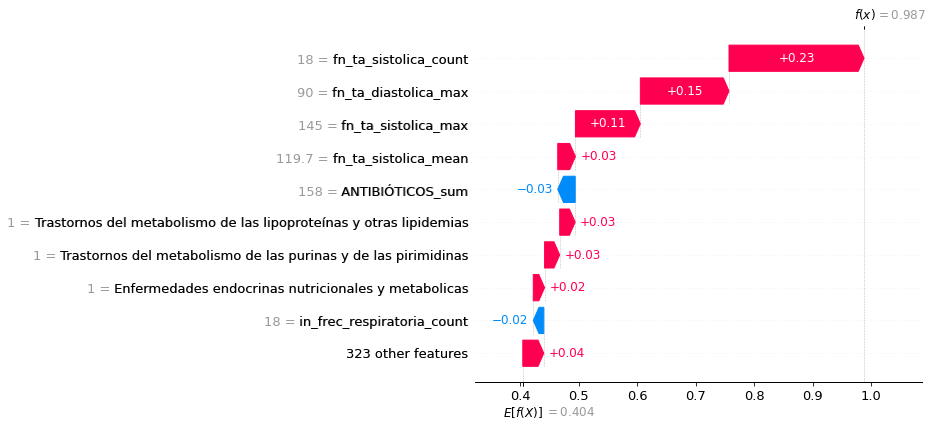

In [32]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

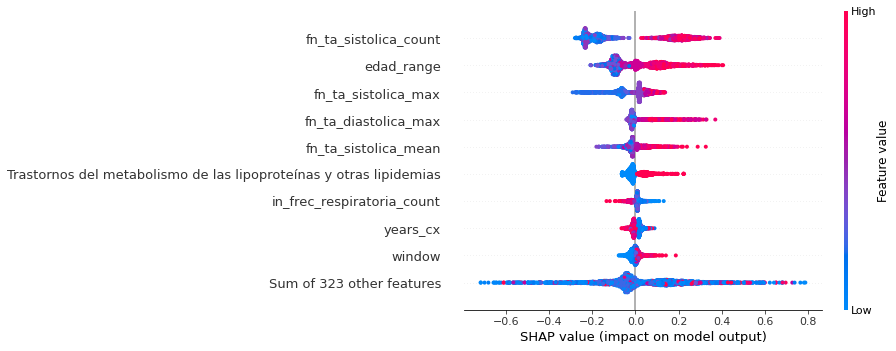

In [33]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

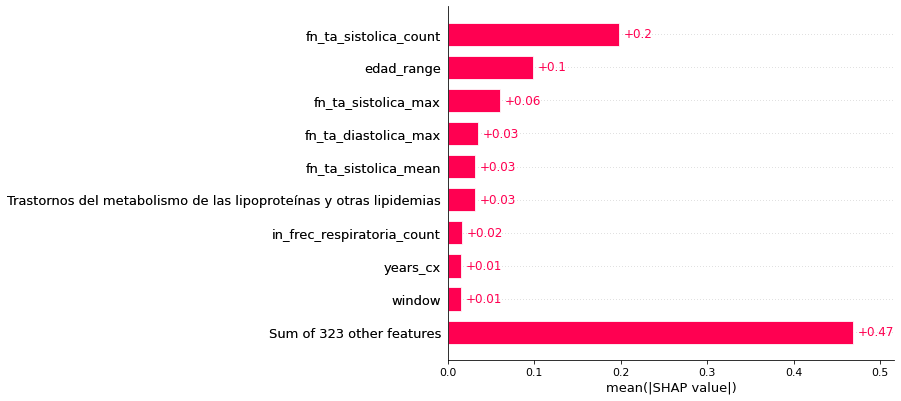

In [34]:
shap.plots.bar(shap_values)